### Add the rectified images together and write out as a fits file

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import ascii, fits
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
from scipy import interpolate
from scipy.optimize import curve_fit
%matplotlib inline

In [8]:
def check_alignment(source, path, fitsfiles, order=106):

    j1 = 30           # starting point of first order -- figured out by hand
    dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
    dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders
    j0 = j1 + (dj_AB + dj_blank) * (order - 99)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xlabel(r"Row (pixels)", fontsize=12)
    ax.set_ylabel(r"Flux (Jy)", fontsize=12)
    plt.suptitle(source)
    for n, f in enumerate(fitsfiles):
        hdu = fits.open(path+f)
        flux = hdu[0].data
        var = hdu[1].data
        hdu.close()

        order_flux = flux[j0:j0+dj_AB, :]
        im_median = np.nanmedian(order_flux, axis=1)
        ax.plot(np.arange(im_median.size), im_median, label=f.strip('rectified').strip('.fits'))

    ax.legend()
    plt.tight_layout()
    plt.savefig(path+source+'_alignment.png')


In [9]:
def weighted_average(path, fitsfiles):

    for n, f in enumerate(fitsfiles):
        hdu = fits.open(path+f)
        flux = hdu[0].data
        var = hdu[1].data
        hdu.close()

        w = 1 / var
        if n == 0:
            flux_sum = w * flux
            weights_sum = w
        else:
            flux_sum += w * flux
            weights_sum += w

    return flux_sum/weights_sum, 1/weights_sum

In [10]:
def plot_combined_image(source, flux, var):
    fig = plt.figure(figsize=(12, 7))

    ax1 = plt.subplot(121)
    #flux_norm = ImageNormalize(flux, interval=MinMaxInterval(), stretch=HistEqStretch(flux))
    flux_norm = ImageNormalize(flux, vmin=-5, vmax=5, stretch=AsinhStretch(0.3))
    ax1.imshow(flux, origin='lower', norm=flux_norm)
    ax1.set_title('Combined Flux')

    ax2 = plt.subplot(122)
    var_norm = ImageNormalize(var, interval=MinMaxInterval(), stretch=HistEqStretch(var))
    ax2.imshow(var, origin='lower', norm=var_norm)
    ax2.set_title('Combined Variance')

    plt.suptitle(source)
    plt.tight_layout()
    plt.savefig(path+source+'_combined.png')
    return

In [11]:
def write_combined_fits(source, path, fitsfiles, flux, var):
    # write out the combined data as a fits file

    # just use the same header as one of the rectified fits files
    # TBD: include more metadata about what is being combined
    hdu = fits.open(path+fitsfiles[0])
    hd0 = hdu[0].header
    hdu.close()

    hdu_flux = fits.PrimaryHDU(flux, header=hd0)
    hdu_var = fits.ImageHDU(var)
    hdu_list = fits.HDUList([hdu_flux, hdu_var])
    hdu_list.writeto(path+source+'_rectified.fits')
    return

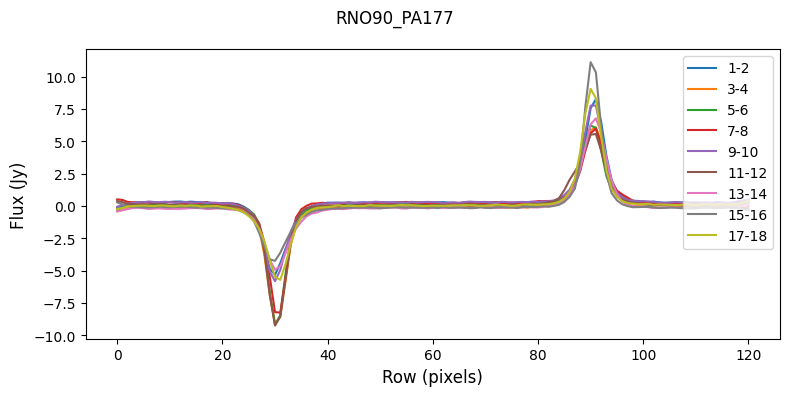

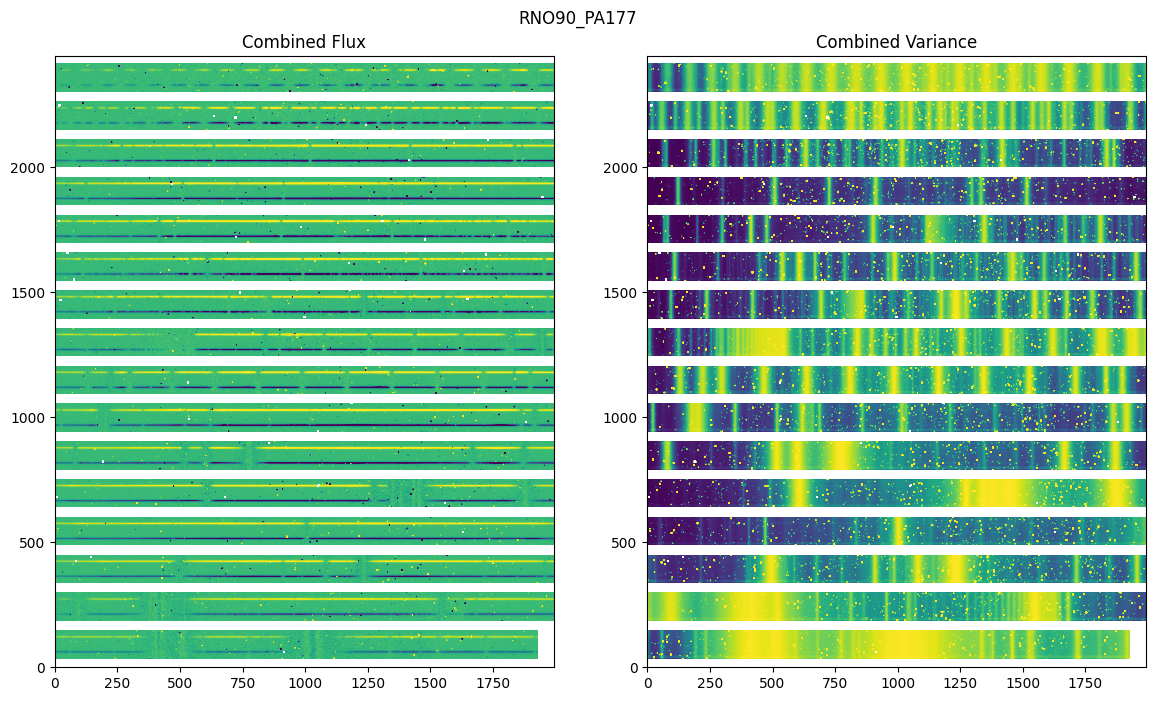

In [20]:
%%capture

# read in the set of rectified files to be combined source by source
# you have to manually create sourcefile.txt in the same directory as the rectified fits files

#path = '/Volumes/JPW_4TB/iSHELL/191008/rectified/'
#path = '/Volumes/JPW_4TB/iSHELL/200221/rectified/'
path = '/Volumes/JPW_4TB/iSHELL/200625/rectified/'
with open(path+'sourcelist.txt') as f:
    all_lines = f.read()
lines = all_lines.split('\n')

# find the breakpoints between sources
nbreak = []
for nline, line1 in enumerate(lines):
    if line1[0:4] == '----':
        nbreak.append(nline)

# read in the source and the associated list of rectified files to combine
for n1 in range(len(nbreak)-1):
    source = lines[nbreak[n1]+1]
    wavecal = lines[nbreak[n1]+2]
    fitsfiles = []
    for n2 in range(nbreak[n1]+3, nbreak[n1+1]):
        fitsfiles.append(lines[n2])

    # probably don't need to check alignment since each rectified file was produced from the same wavecal
    check_alignment(source, path, fitsfiles, order=106)

    flux, var = weighted_average(path, fitsfiles)
    plot_combined_image(source, flux, var)
    write_combined_fits(source, path, fitsfiles, flux, var)
